# Вебинар 3. Коллаборативная фильтрация

Исчерпывающую информацию с теорией, кодом и примерами можно найти в [статье](https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/)

# 1. Матричная факторизация

Раскладываем user-item матрицу на 2: матрицу латентных факторов юзеров и матрицу латентных факторов товаров

- латентый фактор = эмбеддинг (embedding)    

<img src='mf.png'>

In [ ]:
(UхI) = (Uхk) * (kхI)

---

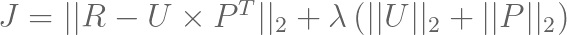

## Alternating Least Squares (ALS)

<img src="als_formula.png" >

$x_u^T$ - user embeddings  
$y_i$ - item embeddings  
$p_{ui}$ - 0/1. 1 - если в матрице user-item эдемент > 0 (было взаимодействие)  
$c_{ui}$ - Вес ошибки = элемент матрицы user-item  
$\lambda_x$, $\lambda_y$ - коэффициенты регуляризации  

**Алгоритм**  
ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах):  

1. Фиксируем эмбеддинги юзеров $x_u^T$ --> легко посчитать производную по эмбеддингам товаров $y_i$
2. Обновляем эмбеддинги товаров (делаем шаг по антиградиенту = градиентный спуск)
3. Фиксируем эмбеддинги товаров $y_i$ --> легко посчитать производную по эмбеддингам юзеров $x_u^T$
4. Обновляем эмбеддинги юзеров (делаем шаг по антиградиенту = градиентный спуск)
5. Повторяем, пока процедура не сойдется

**Плюсы**
- Очень быстрый
- В продакшене можно зафиксировать на весь день эмбеддинги товаров (товары за день не меняются), 
    и в реал-тайм обновлять эмбеддинги юзеров при покупке
- Есть регуляризация $\lambda_x$, $\lambda_y$
- Есть веса ошибок $с_{u_i}$ - элементы матрицы user-item
- Библиотека implicit под капотом использует Cyton - очень быстро работает
- Predict для *всех* юзеров можно сделать просто перемножением 2-ух матриц - очень быстро
- Можно применять различные **взвешивания** матрицы: TF-IDF, BM25, ... . Это сильно улучшает качество

### 1. Базовое применение

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from metrics import precision_at_k, recall_at_k

In [10]:
data = pd.read_csv('retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [11]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [12]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [53]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [54]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [55]:
data_train.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [56]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

C:\Users\NitroPC\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
user_item_matrix

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2498,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [59]:
userid_to_id[1984]

1983

# ALS

In [60]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 2.57 s


In [61]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 999999, 5569230, 1082185]

In [62]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [63]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

Wall time: 41 s


0.16111655239960596

In [64]:
def recs_scoring(model, result):
   
    result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
    
    return result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

In [67]:
%%time

parameters_grid = {
   'factors' : [50, 100, 200], 
   'regularization' : [0.01, 0.001, 0.0001],
   'iterations' : [10, 15, 20], 
   'calculate_training_loss' :[True], 
   'num_threads' : [4],
   'user_item_matrix' : [user_item_matrix]
}

best_score = 0
best_factors = 0
best_regularization = 0
best_iterations = 0

for factors in parameters_grid['factors']:
    for regularization in parameters_grid['regularization']:
        for iterations in parameters_grid['iterations']:
            model = AlternatingLeastSquares(factors=factors, 
                                regularization=regularization,
                                iterations=iterations, 
                                calculate_training_loss=True, 
                                num_threads=4)

            model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
            
            result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
            score = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()
            
            if (score > best_score):
                best_score = score
                best_factors = factors
                best_regularization = regularization
                best_iterations = iterations
                
print(f'Best score = {best_score}')                
print(f'Best factors = {best_factors}')                
print(f'Best regularization = {best_regularization}')                
print(f'Best iterations = {best_iterations}')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Best score = 0.16953966699314163
Best factors = 50
Best regularization = 0.01
Best iterations = 10
Wall time: 14min 14s


In [24]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 979707, 832678, 995242, 1029743]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[929668, 938700, 1133018, 951590, 910032]"


### Embeddings

In [17]:
model.item_factors.shape

(5001, 100)

In [18]:
pd.DataFrame(model.item_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.002757,0.002088,0.002888,0.001052,0.002083,0.003168,0.002871,0.002843,0.002940,0.003029,...,0.000964,0.002188,0.003239,0.001833,0.002866,0.003582,0.001207,0.002409,0.003379,0.001139
1,0.001889,-0.000805,0.003489,0.002981,0.009656,0.002158,0.000492,0.009060,0.006340,0.004372,...,0.004139,0.005743,0.001628,0.004037,0.006457,0.001773,0.002647,0.005601,0.008969,0.003061
2,0.002220,0.001598,0.001530,0.002173,0.003347,0.001791,0.001805,0.005024,0.003119,0.004912,...,0.000398,0.002906,0.003747,0.000167,0.001873,0.002422,0.003724,0.002922,0.002377,0.000927
3,0.002034,0.003051,0.002290,0.003010,0.002654,0.002769,0.003360,0.006354,0.004655,0.004013,...,-0.000315,0.004380,0.004723,0.002608,0.004438,0.003791,0.001302,0.003894,0.003917,0.001608
4,0.002886,0.002817,0.002805,0.001923,0.002897,0.003415,0.003323,0.004263,0.003234,0.003642,...,0.000910,0.002788,0.004036,0.002907,0.003105,0.004008,0.001827,0.003222,0.002785,0.001495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4996,0.008629,0.005082,0.011803,-0.001902,0.010427,-0.001483,0.016271,0.001267,0.005011,0.003960,...,0.004515,0.009871,-0.000602,0.002392,0.007311,0.004529,0.007872,0.003027,0.004886,0.002502
4997,0.007599,0.007687,0.000065,0.000592,0.000317,-0.001178,0.005578,0.008289,0.007609,0.003445,...,-0.000483,0.011401,0.006964,0.001436,0.011550,0.002167,0.004157,0.009180,0.003670,0.004356
4998,0.001442,0.005531,-0.000846,0.000619,0.006050,0.006151,0.006373,0.008417,0.007561,0.006974,...,0.000760,0.006031,0.003642,0.007103,0.007966,0.004112,0.005130,0.000732,0.000236,-0.000023
4999,0.003676,0.005981,0.001542,0.002479,0.004907,-0.002843,0.001142,0.012986,0.004219,0.001445,...,0.000485,0.007938,0.007252,-0.001277,0.009236,0.003595,0.000831,0.007406,0.006544,0.003588


In [19]:
model.user_factors.shape

(2499, 100)

In [20]:
pd.DataFrame(model.user_factors)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3.420595,-4.274535,5.270793,4.741302,-2.641496,-0.589141,-0.529326,-4.822744,-1.703147,-5.438084,...,3.907219,-1.485242,-1.967769,-2.410380,-3.745687,0.919821,2.681515,3.778956,-9.160012,1.206970
1,2.632252,-0.677038,4.671721,2.219255,0.875652,-1.068071,3.768222,-4.253336,4.493767,-8.727695,...,4.398072,-6.889743,-3.764937,-1.104284,-1.770301,0.751536,-1.033763,1.177990,-2.680352,2.731987
2,3.669752,0.885050,6.020555,1.823983,-0.926883,-3.555047,5.157204,-1.021927,1.579793,-5.466113,...,3.532550,-7.955169,-4.302111,-0.560049,-2.818699,-2.642132,-4.431908,1.137004,-1.316822,3.948072
3,3.213346,-1.029150,2.213305,4.061381,-0.292209,-1.614813,3.261544,-1.378403,1.133649,-3.364352,...,1.512689,-3.457905,-4.948671,1.194785,0.421351,-0.390793,-0.143386,-1.325368,-4.538406,-0.808489
4,3.327914,-1.968235,2.154567,3.255939,-2.367795,0.660004,4.452780,1.046989,-0.422564,-3.480871,...,3.954283,-5.429595,-3.115494,1.782394,-0.216805,0.762346,-1.832632,3.891986,-1.344187,1.040242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,7.258043,-1.559430,2.795177,5.359672,0.372253,-0.187744,2.913117,1.610295,4.449583,-0.966419,...,9.067512,1.092216,-5.154342,-3.825964,-4.599781,-1.703278,-3.154456,-2.117317,-0.598207,7.955435
2495,6.112669,1.935125,8.353106,6.607348,-0.667225,-1.296624,-2.357689,-4.426347,6.131649,-0.722581,...,7.812458,-3.811062,-3.323185,1.029958,-9.133304,-0.075471,-4.007853,-2.535552,-4.054787,-1.003847
2496,3.260727,-0.443413,3.142553,4.409231,1.363863,-0.934312,2.029627,-3.566981,-0.444737,-5.452265,...,0.256654,-2.914891,-5.694284,-0.310462,-0.834026,0.143796,-0.659837,1.163052,-1.366115,-0.073439
2497,3.003158,4.177931,-2.147041,5.712822,0.486628,-7.135892,3.526104,-3.645080,3.371619,-4.160272,...,8.357085,-4.983393,-2.599579,-1.163748,-1.006160,0.718262,0.817087,2.243546,-8.424771,-0.520855


Можно очень быстро посчитать предсказания, перемножив эти 2 матрицы

In [21]:
fast_recs = model.user_factors @ model.item_factors.T 
fast_recs.shape

(2499, 5001)

In [22]:
pd.DataFrame(fast_recs)

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,5000
0,0.011437,0.050628,-0.019233,-0.014413,0.013627,0.002601,0.006950,0.272999,0.007400,-0.003793,...,0.194175,0.116254,0.320169,0.121917,0.397792,0.140472,-0.095456,0.042943,0.006263,-0.027761
1,0.009365,0.050574,-0.006486,-0.002446,-0.004535,-0.002547,-0.009655,-0.000518,-0.032949,-0.063676,...,0.034002,0.040144,-0.027908,0.108596,0.120266,0.042260,0.046942,-0.094740,0.058541,0.030017
2,-0.019080,-0.041455,-0.006503,-0.049161,-0.022706,-0.015568,-0.020349,0.102617,-0.003070,0.083403,...,0.027765,-0.050888,0.209533,0.148791,0.118021,0.263906,0.104837,-0.082121,0.101897,-0.076406
3,0.008816,0.065409,0.047412,0.043590,0.006334,0.016000,0.000081,0.108535,0.026129,-0.004791,...,0.040821,0.035099,0.012582,-0.028325,0.044594,0.030153,0.027724,0.060827,0.020937,0.037677
4,-0.000512,0.033939,-0.001520,0.031845,0.001629,0.001470,-0.000637,0.019591,0.060720,0.019692,...,0.005986,-0.007860,-0.000757,0.065783,0.024611,-0.034425,0.053843,-0.023138,0.029160,-0.023950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2494,0.026115,0.086237,0.036034,0.049758,0.022405,0.027758,-0.008598,0.096531,-0.075974,-0.069360,...,0.085929,-0.039659,0.151522,0.167221,0.180687,0.287386,0.169526,-0.021195,0.220026,0.127317
2495,0.018967,0.143822,0.081324,-0.001616,0.016086,0.017933,0.051489,0.111797,-0.007264,0.196693,...,0.011836,0.389770,0.124206,0.065992,0.155724,0.124430,0.093104,0.010808,0.105068,0.014425
2496,0.039632,0.103728,-0.001601,0.015276,0.005486,0.003653,0.010434,-0.077197,-0.025485,-0.023843,...,0.086192,0.095821,0.074791,0.106430,0.147866,0.167614,0.031391,0.038716,0.056784,0.075887
2497,-0.023814,0.090145,0.015645,-0.019652,-0.017345,-0.006765,-0.005201,0.055025,0.319023,0.057886,...,-0.024692,-0.009622,-0.029304,-0.060822,0.039059,0.136626,0.197538,0.039872,0.055845,0.280542


In [23]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import cm
import pickle

from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns


def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [24]:
model.item_factors.shape

(5001, 100)

In [48]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [49]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


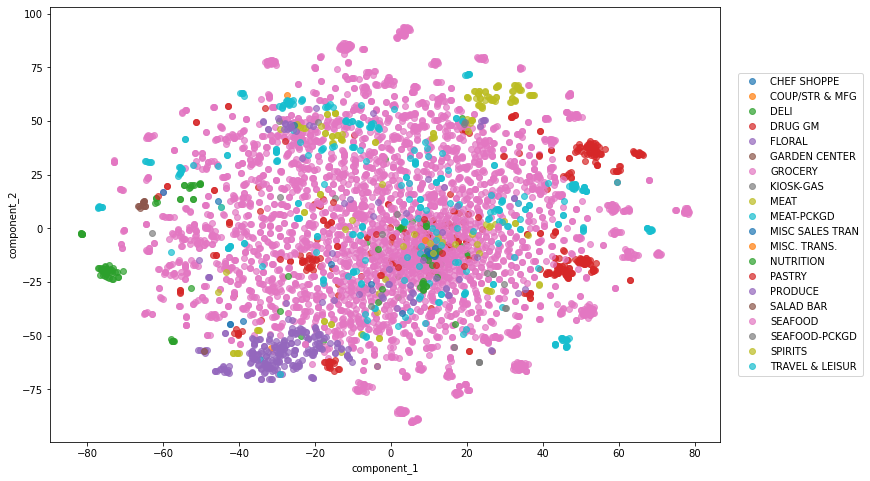

Wall time: 16.6 s


In [50]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']

display_components_in_2D_space(item_emb_tsne, labels='category')

Нарисуем все, кроме GROCERY

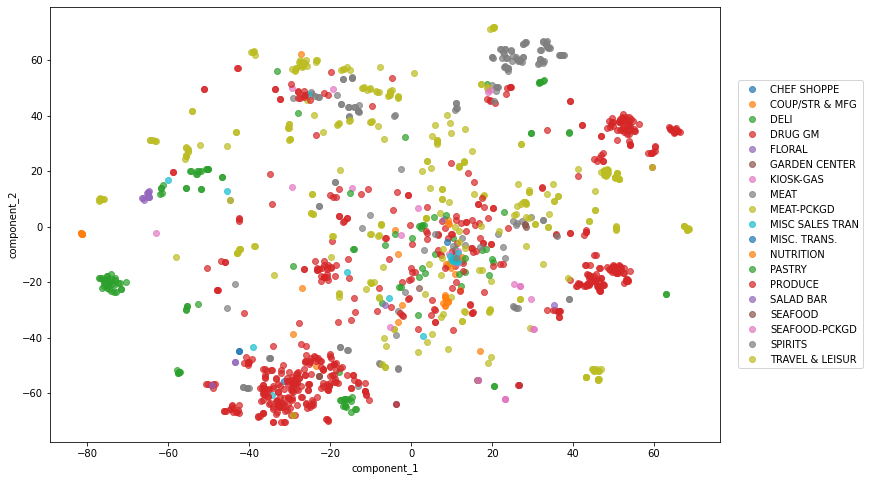

In [51]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Нарисуем несколько конкретных категорий

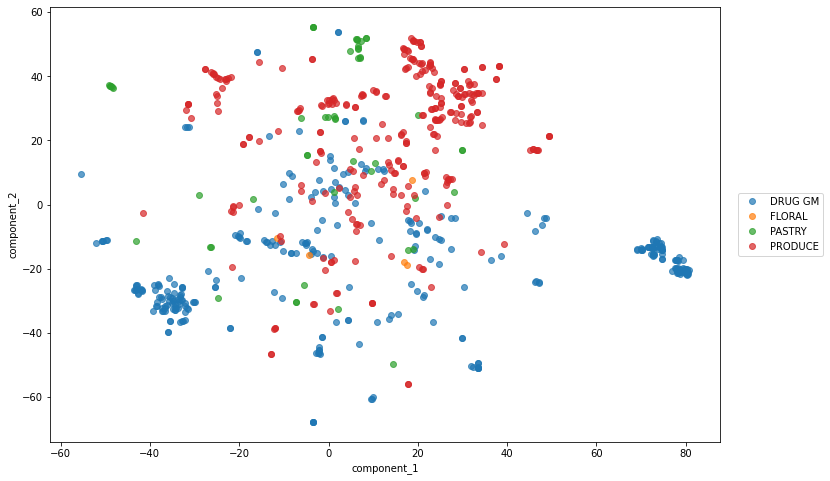

In [29]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

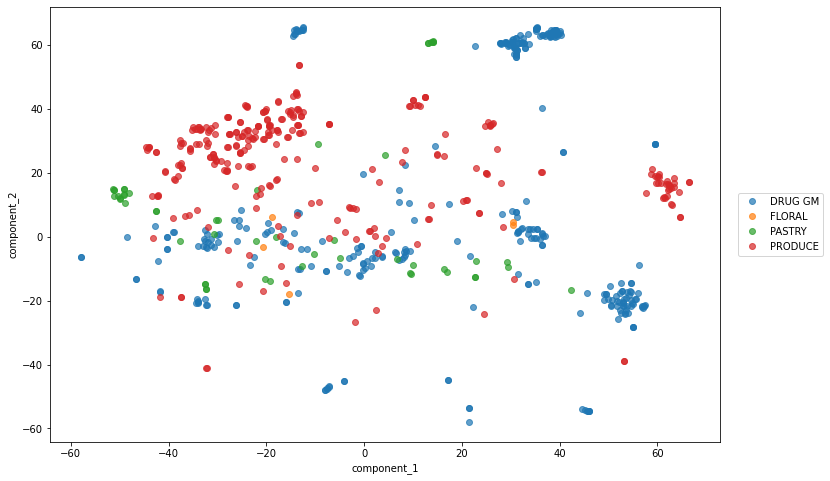

In [43]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

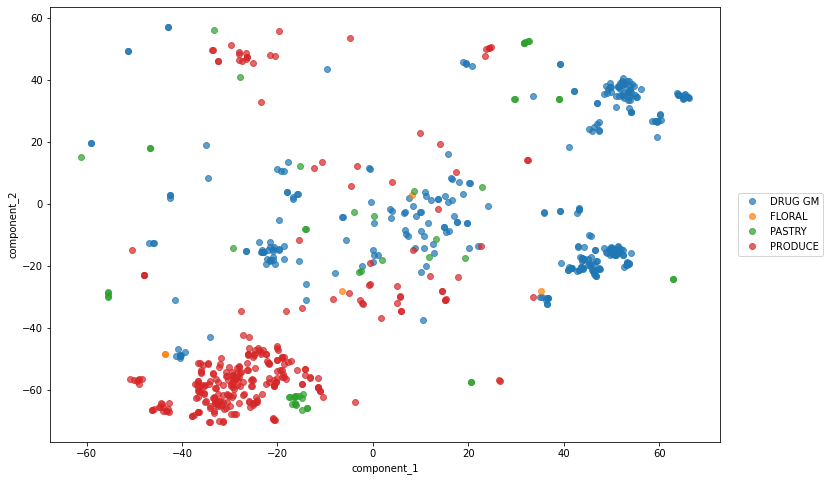

In [52]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                                             labels='category')

На самом деле, я бы сказал, что **результат средний**:
- Модель выучила похожесть только небольшой части товаров

In [32]:
item_emb_tsne.head(2)

,component_1,component_2,category
0,-0.741553,-14.246434,MISC SALES TRAN
1,2.732925,-13.653527,KIOSK-GAS


recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [30]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=csr_matrix(user_item_matrix).tocsr(),
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2499 [00:00<?, ?it/s]

Wall time: 18.5 s


In [31]:
recommendations.shape

(2499, 5)

In [32]:
pd.DataFrame(recommendations)

,0,1,2,3,4
0,1927,2696,832,3616,1150
1,2148,2307,662,2927,4346
2,558,1668,3388,195,2765
3,3408,3587,4346,110,340
4,3408,2148,3133,2307,3587
...,...,...,...,...,...
2494,4287,195,1923,2434,1927
2495,225,1419,2377,70,2765
2496,4346,558,2148,3587,3133
2497,2847,300,3704,3322,845


In [36]:
item_1 = model.item_factors[1]
item_2 = model.item_factors[2]

In [37]:
item_1.shape

(100,)

In [38]:
item_1

array([ 0.00310878,  0.00405952, -0.0037532 ,  0.00248557,  0.00687427,
        0.0076246 ,  0.0042018 ,  0.00581163, -0.00221727, -0.00034427,
        0.00618214, -0.00031666,  0.00590764,  0.0037421 ,  0.00056225,
        0.0068076 ,  0.00392615,  0.00218227,  0.00593587,  0.0047393 ,
        0.00237064,  0.00549642,  0.00347213,  0.00635066,  0.00118344,
        0.00278085,  0.00041047, -0.00197838,  0.000716  , -0.00645592,
        0.00253054,  0.00474804,  0.00247434,  0.00087301,  0.00153631,
        0.00093124,  0.00445833,  0.00347937,  0.00419013,  0.00223143,
       -0.00267223,  0.00117819, -0.00519523,  0.00337711,  0.00668837,
       -0.00049365,  0.00568359,  0.00419678,  0.00576765,  0.00169795,
        0.00415628,  0.00684942,  0.0055715 ,  0.00480572,  0.0037447 ,
       -0.00231772,  0.00233173, -0.00157418,  0.00592333,  0.00676574,
        0.00139921, -0.00149086,  0.00252786,  0.00575717,  0.00470375,
        0.00521702,  0.004587  ,  0.00413893,  0.0027191 ,  0.01

*Посмотрите также / Похожие товары*

In [33]:
example_item_row_id = 3606

In [34]:
closest_items = [ id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [35]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
14959,899459,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT CHUNKS,1 LB
17974,925437,69,GROCERY,Private,BAKED SWEET GOODS,SWEET GOODS - FULL SIZE,13 OZ
19724,940631,667,GROCERY,National,BAKING NEEDS,BAKING POWDER & SODA,16 OZ
25270,990804,69,GROCERY,Private,VEGETABLES - SHELF STABLE,MUSHROOMS CND & GLASS,4.5 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [36]:
model.similar_users(userid_to_id[10], N=5)

[(9, 0.99999994),
 (354, 0.973889),
 (239, 0.97286004),
 (1380, 0.9720655),
 (790, 0.9709712)]

### 2. TF-IDF взвешивание

In [37]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [38]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 22.3 s


0.16503428011753182

### 3. BM25 взвешивание

In [7]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

NameError: name 'top_5000' is not defined

In [45]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [46]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 30.2 s


In [47]:
result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.19000979431929482

In [54]:
result

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[995242, 1029743, 5569374, 1033142, 962568]","[1051211, 1033142, 986912, 1105488, 999999]","[999999, 995242, 1082185, 965766, 5569374]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[5568378, 1106523, 1133018, 910032, 9337581]","[1106523, 1133018, 951590, 999999, 1098066]","[999999, 951590, 1133018, 1053690, 1092026]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1007195, 866211, 1023720, 878996, 904360]","[1051516, 878996, 1007195, 1023720, 1024306]","[1023720, 1024306, 1082185, 1007195, 1051516]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1058997, 999999, 1082185, 893018, 1133018]","[999999, 1082185, 1126899, 826249, 938700]","[999999, 849843, 1058997, 1082185, 5583595]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[938700, 826249, 1053690, 1098066, 913785]","[979707, 1053690, 1004906, 1068719, 913785]","[999999, 840361, 883404, 1004906, 965766]"
...,...,...,...,...,...
2037,2496,[6534178],"[914190, 1133018, 1013321, 6534178, 938700]","[914190, 1133018, 962568, 847982, 840361]","[914190, 999999, 1133018, 916122, 840361]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[5569230, 5569845, 883932, 951590, 1051323]","[5569230, 951590, 5569471, 5569845, 957951]","[5569230, 957951, 995785, 999999, 854852]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1053690, 999999, 9526410, 1070820, 1082185]","[999999, 1053690, 6534178, 1082185, 862349]","[999999, 840361, 862349, 995242, 861272]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6534178, 938700, 1004906, 1038217, 826249]","[965766, 883404, 6534178, 826249, 1098066]","[999999, 1053690, 1098066, 826249, 883404]"


In [53]:
result.to_csv('predictions_mf.csv', index=False)  # mf - matrix factorization

## 4. Важно искать оптимальные параметры

- regularization, iterations
- factors
- Вес (элемент в матрице user-item)

-----

# Production

Начиная с этого вебинара, мы будем строить *базовое решение* для системы рекомендаций топ-N товаров. В финальном проекте вам нужно будет его сущесвтенно улучшить.  
  
**Ситуация**: Вы работает data scientist в крупном продуктовом российском ритейлере. Ваш конкурент сделал рекомендательную систему, и его продажи выросли. Ваш менеджмент тоже хочет увеличить продажи   
**Задача со слов менеджера**: Сделайте рекомендательную систему топ-10 товаров для рассылки по e-mail

**Ожидание:**
- Отправляем e-mail с топ-10 товарами, отсортированными по вероятности

**Реальность:**
- Чего хочет менеджер от рекомендательной системы? (рост показателя X на Y% за Z недель)

Менеджер суть нисшая форма жизни.<br>
Нисшие формы жизни желают одного: максимизации удовольствия/минимизации страданий.<br>
Менеджер суть бюрократ. Бюрократы подчиняются Железному Закону Бюрократии: "В любой бюрократической системе те, кто работает на благо самóй бюрократии, всегда захватывают власть."<br>
От рекомендательной системы менеджер хочет того же, что и от всего остального: демонстрацию его (менеджера) полезности для начальства, от которого зависят его удовольствия/страдания.<br>
Начальство менеджера - капиталист, владелец капитала. Капитал - самовозрастающая стоимость. Цель жизни капиталиста - умереть с наибольшим количеством капитала в своей собственности.<br>
Полезность менеджера для капиталиста - та же, что и полезность всего остального: прибыль, увеличение капитала.<br>
Современный капитал - капитал финансовый, он может быть быстро инвестирован и быстро ликвидирован. Следствие: важны только хронологически ближайшие эффекты инвестиций.<br>

Вывод:
1) Максимизируемый параметр - прибыль.<br>
2) Первичное ограничение - время.<br>
3) Вторичное ограничение - величина эффекта.<br>
"Лучше немного и завтра, чем много, но в удалённой перспективе."

- По-хорошему надо бы предварительно посчитать потенциальный эффект от рекоммендательной системы (Оценки эффектов у менеджера и у вас могут сильно не совпадать: как правило, вы знаете про данные больше)
- А у нас вообще есть e-mail-ы пользователей? Для скольки %? Не устарели ли они?

Необходимо ввести учёт откликов на электронные письма. Если с определённого адреса на эти письма откликов (в течение длительного времени) нет - следует удалять такой адрес из базы. В ином случае велик риск определения этой рассылки почтовыми серверами как спама и автоматического отправления данных писем в соответствующую категорию в почтовых ящиках.

- Будем ли использовать СМС и push-уведомления в приложении? Может, будем печатать рекомендации на чеке после оплаты на кассе?

Бесит ли вас, когда вам отвечают на вопрос, который вы не задавали? Вот получение СМС вызывает ровно такое же раздражение у получателя. Приложения и чеки - куда меньше, так как они подразумевают, что клиент вступил с вами в некие коммерческие отношения и явно выразил интерес.

- Как будет выглядеть e-mail? (решаем задачу топ-10 рекомендаций или ранжирования? И топ-10 ли?)

В общем случае - это не вопрос к DS'у. В организации, как правило, есть много других людей с занятостью поменьше и временем подешевле, чтобы решать вопросы содержания и визуального дизайна рекламных материалов. С точки зрения Data Science - нужно разработать несколько (значимо различных) вариантов материалов, применить их на репрезентативных выборках целевой аудитории и сравнить полученную эффективность.

И заодно - уволить половину тех, кто решает вопросы содержания и визуального дизайна рекламных материалов, а их зарплату - отдать DS'у, делающему за них их работу =Ъ

- Какие товары должны быть в e-mail? Есть ли какие-то ограничения (только акции и т п)?

Зависит от профиля потребления конкретного пользователя. Есть аскеты, покупающие немного и равнодушные к акциям. Есть нищеброды, старающиеся купить дорогое подешевле. Есть множество других возможных категорий. Подобная кластеризация пользователей по ценовым категориям товаров и интересу в акциях - тема отдельного исследования данных.

- Сколько денег мы готовы потратить на привлечение 1 юзера? CAC - Customer Aquisition Cost. Обычно CAC = расходы на коммуникацию + расходы на скидки
- Cколько мы хотим зарабатывать с одного привлеченного юзера?

Вопросы к бухгалтерии, не к DS.

В общем случае такие вопросы, направленные к DS, являются нарушением гильотины Юма: Data Science, как и всякая наука, занимается вопросами о том, "что есть". Вопросы же из разряда "на что готовы" и "что хотим" к сфере DS не относятся.

---
- А точно нужно сортировать по вероятности?
- Какую метрику использовать?
- Сколько раз в неделю отпрпавляем рассылку?
- В какое время отправляем рассылку?

Все эти вопросы решаются эмпирически.

- Будем отправлять одному юзеру много раз наши рекоммендации. Как добиться того, чтобы они хоть немного отличались?

Ввести память на отправленные рекоммендации и штрафовать модель за частые повторы.

- Нужно ли, чтобы в одной рассылке были *разные* товары? Как определить, что товары *разные*? Как добиться того, чтобы они были разными?

Определить для товаров классы эквивалентности по операции "взаимозаменяемости" и не рекоммендовать одновременно более одного товара из одного такого класса, так как явно, что два таких товара один пользователь с высокой вероятностью не купит, а значит такие рекомендации (в условиях ограниченного количества мест в списке рекоммендаций) неэффективны.

- И многое другое:)

**В итоге договорились, что:**
- Хотим повысить выручку минимум на 6% за 4 месяца. Будем повышать за счет роста Retention минимум на  3% и среднего чека минимум на 3%
- Топ-5 товаров, а не топ-10 (В e-mail 10 выглядят не красиво, в push и на чек больше 5 не влезает)
- Рассылаем в e-mail (5% клиентов) и push-уведомлении (20% клиентов), печатаем на чеке (все оффлайн клиенты)
- **3 товара с акцией** (Как это учесть? А если на товар была акция 10%, а потом 50%, что будет стоять в user-item матрице?)

Разделить всё множество товаров на "товары с акцией" и "товары без акции" и набирать эти три позиции только из первого подмножества.

- **1 новый товар** (юзер никогда не покупал. Просто фильтруем аутпут ALS? А если у таких товаров очень маленькая вероятность покупки? Может, использовать другую логику/модель?) 

Вариантов множество:
1) Снова прибегаем к классам взаимозаменяемости: генерируем рекомендацию как обычно, затем берём товар из рекомендации и заменяем его на другой, взаимозаменяемый с ним товар. К примеру, на новый товар из ассортимента (где его "очень маленькая вероятность покупки" объясняется как раз его новизной - его ещё не успели много напокупать).

2) Занудный "с этим товаром обычно берут": смотрим на обычно покупаемые пользователем товары, смотрим на скоррелированные с ними товары, которые этот пользователь не берёт, предлагаем один из этих товаров.

3) Забавный "для расширения горизонтов": берём товар, который можем прорекламировать как-то забавно. Люди любят развлечения. Сам товар они, может, и не купят, но в целом рекомендации будут меньше их бесить, и, возможно, к остальным рекомендациям они отнесутся более благосклонно. А может и купят то, что "они до этого момента никогда не знали, что это им нужно".

- **1 товар для роста среднего чека** (товары минимум дороже чем обычно покупает юзер. Как это измерить? На сколько дороже?)

То, что товар "дороже", измеряется по его цене, очевидно. Предлагать, снова, из классов взаимозаменяемости: берём тот товар, что покупался обычно, берём его цену и класс, находим товар из того же класса, но с ценой чуть повыше. Бонусные очки, если на него есть акция со скидками.

Вопросов стало еще больше. Поэтому сначала делаем **MVP** (Minimum viable product) на e-mail. Показываем его менеджеру, измеряем метрики на юзерах. По фидбеку и метрикам делаем улучшения MVP и раскатываем его на push-уведомления и чеки

*Data Science проект* - итеративный процесс!

In [3]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

C:\Users\NitroPC\AppData\Local\Temp/ipykernel_16856/1027606932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

In [5]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [6]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [ ]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят) 
    
    # А вам не кажется, что это самосбывающееся пророчество, и эти товары не покупают потому, что вы их не рекламируете?
    # С другой стороны: а зачем вообще в ассортименте магазина товары, которые "не купят"?
    
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товары
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

Все эти функции отправим затем в *utils.py*

# ДЗ

1) Попытаться ответить на вопросы/выдвинуть гипотезы

2) Доделать прошлые домашния задания

3) Прочитать статьи BM25/MatrixFactorization

4) Поэкспериментировать с ALS (grid-search)

# Links

BM25

https://en.wikipedia.org/wiki/Okapi_BM25#:~:text=BM25%20is%20a%20bag%2Dof,slightly%20different%20components%20and%20parameters.


Matrix factorization (ALS, SVD)
https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/